# 1) Import

In [11]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

# 2) Generator

## 2-1) contractor

In [12]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_dropout = False, use_bn = True):
        super(ContractingBlock, self).__init__()
        # Build the neural network
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size = 3, padding = 1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

## 2-2) expander

In [13]:
class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_dropout = False, use_bn = True):
        super(ExpandingBlock, self).__init__()
        # Build the neural network
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size = 2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size = 2, padding = 1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()  # "each followed by a ReLU"
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis = 1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

## 2-3) crop

In [14]:
def crop(image, new_shape):
    middel_height = image.shape[2] // 2
    middel_width = image.shape[3] // 2
    starting_height = middel_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middel_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]

    return cropped_image

#3 2-4) feature map

In [15]:
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size = 1)

    def forward(self, x):
        x = self.conv(x)
        return x

## 2-5) UNet

In [16]:
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels = 32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout = True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout = True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout = True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)

# 3) Discriminator

In [17]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels = 8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn = False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)

        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size = 1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis = 1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

# 4) 기타

## 4-1) 초기화

In [18]:
import torch.nn.functional as F
# New parameters
adv_criterion = nn.BCEWithLogitsLoss()
recon_criterion = nn.L1Loss()
lambda_recon = 200

n_epochs = 20
input_dim = 3
real_dim = 3
display_step = 200
batch_size = 4
lr = 0.0002
target_shape = 256
device = 'cpu'

## 4-2) 데이터 로딩

In [19]:
transform = transforms.Compose([transforms.ToTensor()])

import torchvision
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/maps", transform = transform)

## 4-3) optimizer

In [20]:
gen = UNet(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

pretrained = False
if pretrained:
    loaded_state = torch.load("pix2pix_15000.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

# 5) Loss 함수

In [21]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    # Steps: 1) Generate the fake images, based on the conditions.
    #        2) Evaluate the fake images and the condition with the discriminator.
    #        3) Calculate the adversarial and reconstruction losses.
    #        4) Add the two losses, weighting the reconstruction loss appropriately.

    fake = gen(condition)
    disc_fake_hat = disc(fake, condition)
    gen_adv_loss = adv_criterion(disc_fake_hat, torch.ones_like(disc_fake_hat))
    gen_rec_loss = recon_criterion(real, fake)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss

    return gen_loss

# 6) Image display

In [22]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow = 5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# 7) Training

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Pretrained initial state


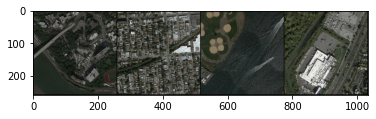

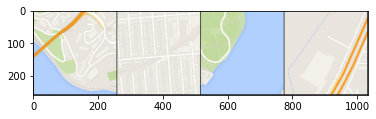

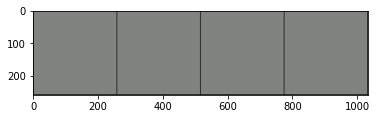

Epoch 0: Step 200: Generator (U-Net) loss: 73.98567279815673 Discriminator loss: 0.6555982816219327


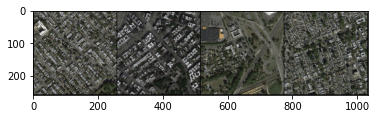

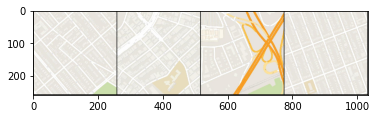

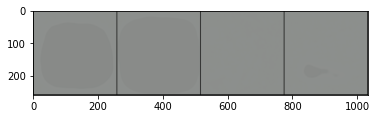

KeyboardInterrupt: ignored

In [23]:
from skimage import color
import numpy as np

def train(save_model = False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(dataloader):
            image_width = image.shape[3]
            condition = image[:, :, :, :image_width // 2]
            condition = nn.functional.interpolate(condition, size = target_shape)
            real = image[:, :, :, image_width // 2:]
            real = nn.functional.interpolate(real, size = target_shape)
            cur_batch_size = len(condition)
            condition = condition.to(device)
            real = real.to(device)
          
            ### Update discriminator ###
            disc_opt.zero_grad() # Zero out gradient before backpropagation
            with torch.no_grad():
                fake = gen(condition)
            disc_fake_hat = disc(fake.detach(), condition)  # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(real, condition)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph = True)  # Update gradients
            disc_opt.step()  # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
            gen_loss.backward()  # Update gradients
            gen_opt.step()  # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss} Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                show_tensor_images(condition, size = (input_dim, target_shape, target_shape))
                show_tensor_images(real, size = (real_dim, target_shape, target_shape))
                show_tensor_images(fake, size = (real_dim, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                                'gen_opt': gen_opt.state_dict(),
                                'disc': disc.state_dict(),
                                'disc_opt': disc_opt.state_dict()
                    }, f"pix2pix_{cur_step}.pth")
            cur_step += 1
train()